In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile
import glob
from PIL import Image
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
import wandb
wandb.init(project='DogVsCat', save_code=True)

wandb: Currently logged in as: dilettante258. Use `wandb login --relogin` to force relogin


wandb: Network error (TransientError), entering retry loop.


In [2]:
import os

train_dir = 'train'
test_dir = 'test'

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 15625
Test Data: 9375


In [3]:
# labels = [path.split('\\')[-1].split('.')[0] for path in train_list]
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

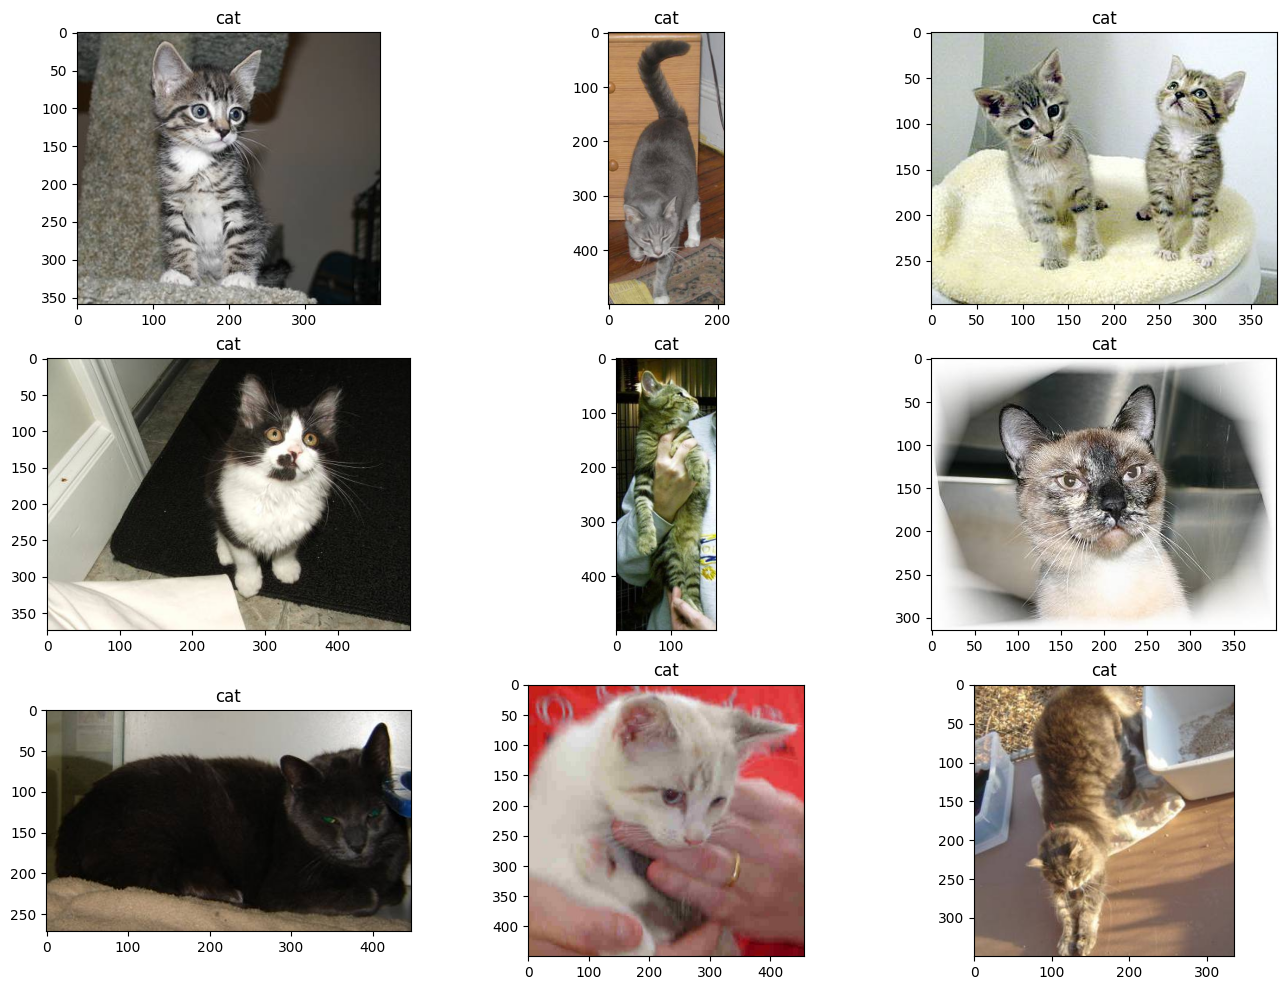

In [4]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [5]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=0)

In [6]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 12500
Validation Data: 3125
Test Data: 9375


In [7]:
train_transforms = transforms.Compose([
    # TODO: define traininig augmentations 
    transforms.Resize(256),  # Resize the image to a fixed size
    transforms.CenterCrop(224),  # Crop the center of the image
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust color jitter
    # transforms.RandomRotation(degrees=20),  # Randomly rotate the image
    transforms.RandomRotation(degrees=(120, 120)),#, expand=True
    # transforms.RandomApply(transforms=[transforms.RandomResizedCrop(scale=(0.5, 1.0))], p=0.6),
    
    #transforms.ColorJitter(brightness=0.2, hue=0.1),  
    #transforms.ToPILImage(),
    #transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), 
    #MobileNet Mean: [0.485, 0.456, 0.406] Standard Deviation (std): [0.229, 0.224, 0.225]
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transforms = transforms.Compose([
    # TODO: define test augmentations
    transforms.Resize(256),  # Resize the image to a fixed size
    transforms.CenterCrop(224),  # Crop the center of the image
    transforms.RandomInvert(p=1),  
    #transforms.ToPILImage(),
    #transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.filelength = len(file_list)

    def __len__(self):
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img).to(device)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [10]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=train_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [11]:
batch_size = 64
test_batch_size = 64
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=test_batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


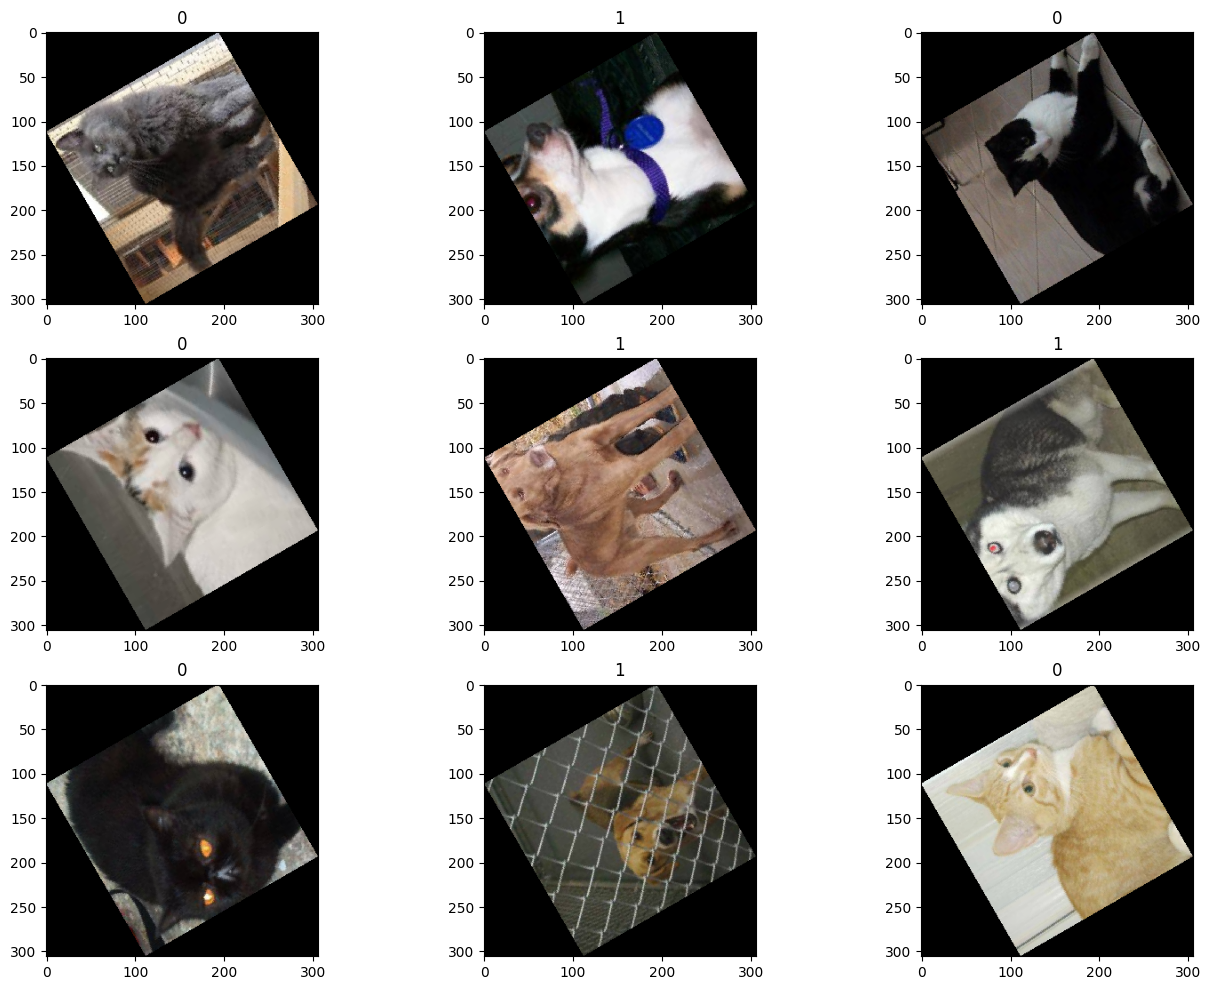

In [50]:
# Create a new dataset with only the transform applied
transformed_dataset = CatsDogsDataset(train_list, transform=train_transforms)
#transformed_dataset = CatsDogsDataset(test_list, transform=test_transforms)
# Create a data loader for the transformed dataset
transformed_loader = DataLoader(dataset=transformed_dataset, batch_size=9, shuffle=True)

# Fetch a batch of transformed images
transformed_batch, transformed_labels = next(iter(transformed_loader))

# Move the batch to CPU if it's on GPU
transformed_batch_cpu = transformed_batch.cpu()

# Convert the batch to NumPy array
transformed_np = transformed_batch_cpu.numpy()

# Plot the transformed images
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

# Define the denormalization parameters
denorm_mean = np.array([0.485, 0.456, 0.406])
denorm_std = np.array([0.229, 0.224, 0.225])

for i in range(9):
    ax = axes.ravel()[i]
    img = transformed_np[i].transpose(1, 2, 0)  # Transpose to (H, W, C) for displaying with matplotlib
    
    # Denormalize the image using new mean and std values
    img = img * denorm_std + denorm_mean
    
    ax.set_title(transformed_labels[i].item())
    ax.imshow(img)
    
plt.show()

In [13]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training parameters
num_epochs = 30
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    start_time = time.time() 
    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Print training loss at the end of each epoch
    end_time = time.time()  # Record the end time for the epoch
    epoch_time = end_time - start_time  # Calculate the time taken for the epoch
    average_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train  
    # Append training metrics to lists
    train_losses.append(average_loss)
    train_accuracies.append(train_accuracy)
    # Log training accuracy and loss to WandB
    wandb.log({"train_loss": average_loss, "train_accuracy": train_accuracy})
    print(f'Training Loss: {average_loss}, Training Accuracy: {train_accuracy}, Time: {epoch_time} seconds')
    
    # Evaluate the model on the validation set
    model.eval()
    correct_val = 0
    total_val = 0
    val_running_loss = 0.0    
    start_val_time = time.time()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Print validation loss and accuracy
    validation_loss = val_running_loss / len(valid_loader)
    validation_accuracy = correct_val / total_val
    end_val_time = time.time()  # Record the end time for validation
    val_epoch_time = end_val_time - start_val_time
    # Append validation metrics to lists
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)
    # Log Validation accuracy and loss to WandB
    wandb.log({"validation_loss": validation_loss, "validation_accuracy": validation_accuracy})
    print(f'Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}, Validation Time: {val_epoch_time} seconds')

Epoch [1/30]
Training Loss: 0.49119198518539114, Training Accuracy: 0.91304, Time: 115.29140162467957 seconds
Validation Loss: 0.0797647068429054, Validation Accuracy: 0.97024, Validation Time: 15.953279733657837 seconds
Epoch [2/30]
Training Loss: 0.04451170317859541, Training Accuracy: 0.98376, Time: 108.82195544242859 seconds
Validation Loss: 0.05452775721419222, Validation Accuracy: 0.97952, Validation Time: 19.499439239501953 seconds
Epoch [3/30]
Training Loss: 0.02627486510532528, Training Accuracy: 0.99048, Time: 103.69513988494873 seconds
Validation Loss: 0.06882729305296528, Validation Accuracy: 0.97664, Validation Time: 14.003900051116943 seconds
Epoch [4/30]
Training Loss: 0.017004533427172314, Training Accuracy: 0.99432, Time: 94.4144856929779 seconds
Validation Loss: 0.061400374523554076, Validation Accuracy: 0.97952, Validation Time: 14.486501693725586 seconds
Epoch [5/30]
Training Loss: 0.010990719711859425, Training Accuracy: 0.99592, Time: 100.85552144050598 seconds
Va

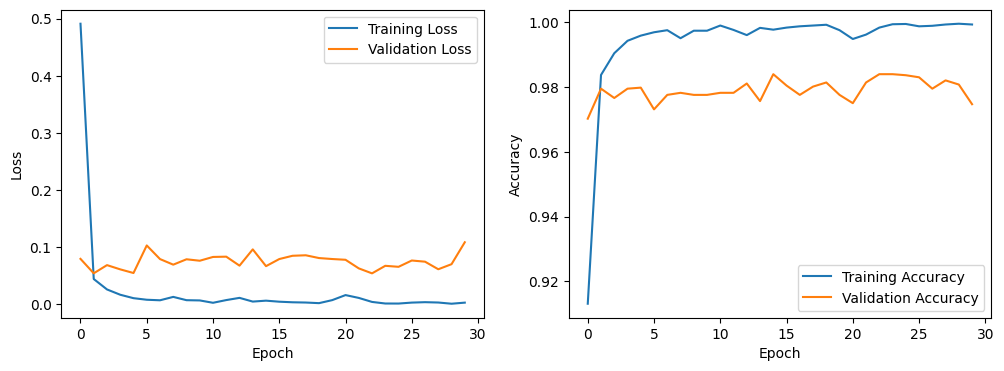

In [14]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


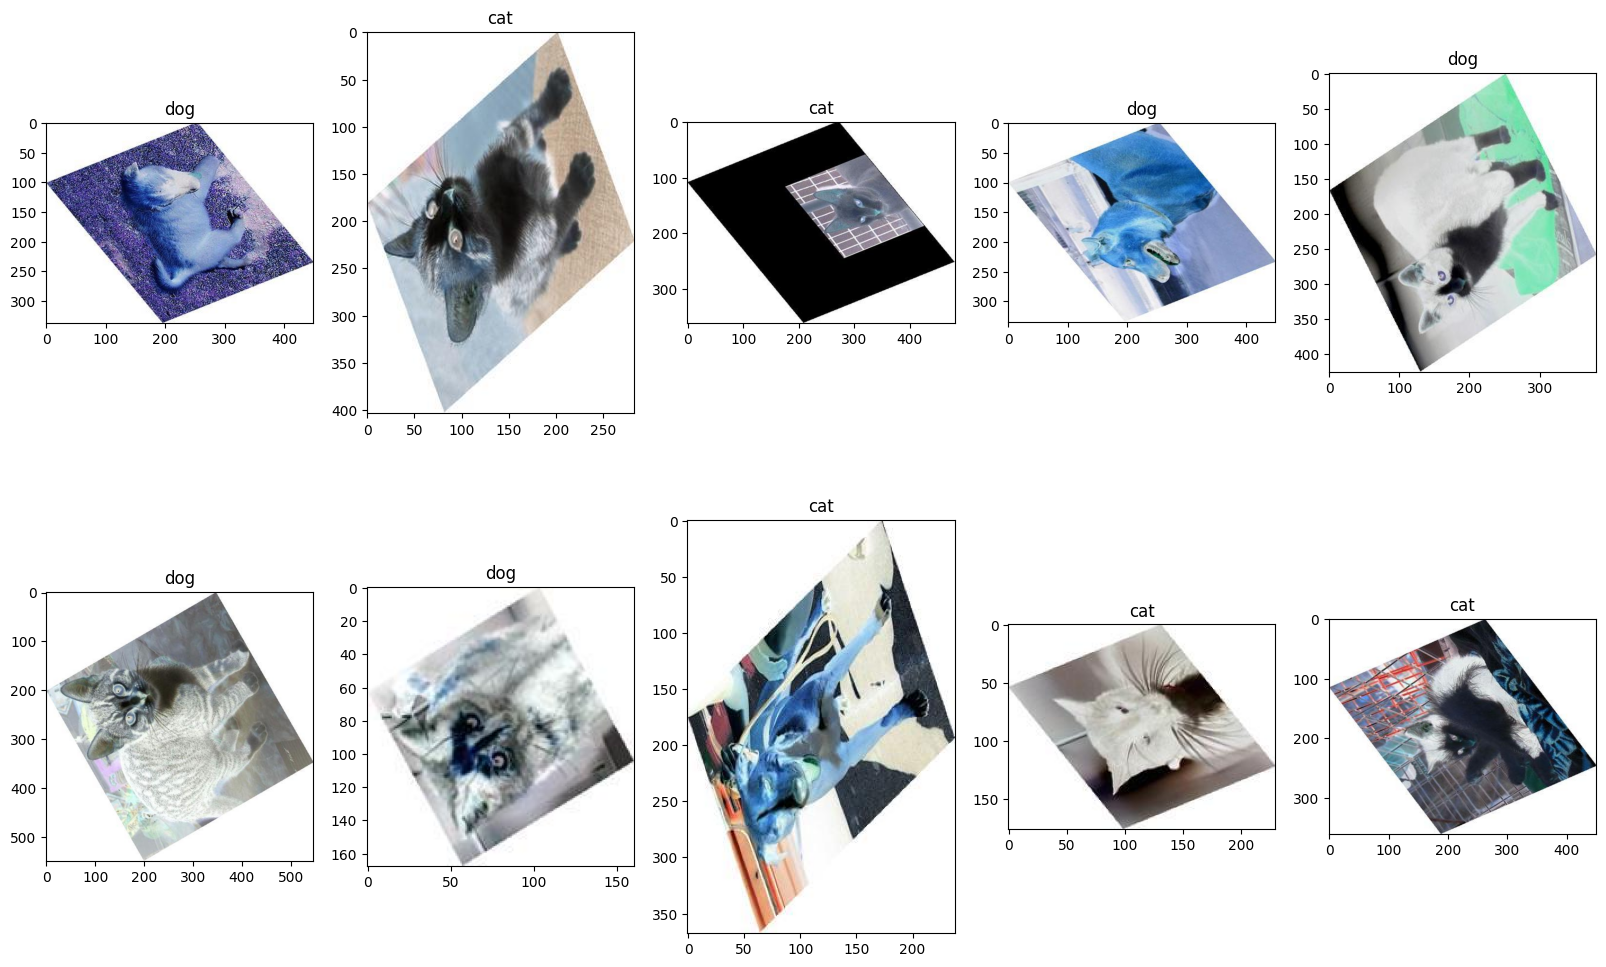

In [46]:
import random

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(out_df['ID'].values)
    
    label = out_df.loc[out_df['ID'] == i, 'TARGET'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)

In [51]:
# Validation loop
model.eval()
predictions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'id': [os.path.splitext(os.path.basename(file))[0] for file in test_list],
    'label': predictions
})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)